In [66]:
import pandas as pd
from yahoo_fin.stock_info import *
import numpy as np
import math
from datetime import date
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output



# Stock class instructions

The stock class can be instantiated by giving an asset ticker as listed by yahoo finance

What each of the stock class methods does: 

`prices`: Returns a list of the monthly adjusted close prices from 01/01/2015 to the current day <br>
`period_returns`: Returns a list of the returns per period in percentage form <br>
`mean_return`: Gets the monthly mean returns for the asset <br>
`risk`: Gets the risk(variance) of the assset <br>





In [2]:
class Stock: 

    def __init__(self, ticker, period="1mo"):
        self.ticker = ticker
        self.period = period

# Gets the adjusted close of a ticker per a certain period
    def prices(self):
        price_data = get_data(self.ticker, start_date="01/01/2015",end_date = datetime.date.today(), index_as_date = True, interval=self.period)
        adjclose = price_data.loc[:, 'adjclose']
        return adjclose.tolist()


    # Gets a list of the returns per period in percentage form
    def period_returns(self):
        adjclose_list = self.prices()

    # Loops through the adjusted closes and sums the ubiased daily return divided by the length of the list
        period_returns = []

        for i in range(len(adjclose_list) - 1):
            daily_return = np.log(adjclose_list[i+1]/adjclose_list[i]) * 100
            if np.isnan(daily_return) == False:
                period_returns.append(daily_return)
        
        return period_returns

    # Gets the mean return of the stock per-period
    def mean_return(self):
        period_returns = self.period_returns()

        mean_return = sum(period_returns)/len(period_returns)
        return mean_return

    # Gets the standard deviation of a certain stock
    def risk(self):
        period_returns = self.period_returns()
        return (np.std(period_returns, dtype=np.float64))


In [7]:
stock_text = widgets.Text(
    description='Stock ticker:',
    disabled=False
)

# Mean return
def mean_return_event(obj):
    new_stock = Stock(stock_text.value)
    mean_rtrn = new_stock.mean_return()
    value = stock_text.value
    print(value.upper(),"mean return:", str(mean_rtrn),"%")

mean_return_btn = widgets.Button(description='Get mean return')
mean_return_btn.on_click(mean_return_event)

# Risk
def risk_event(obj):
    new_stock = Stock(stock_text.value)
    risk = new_stock.risk()
    value = stock_text.value
    print(value.upper(),"risk:", str(risk))


risk_btn = widgets.Button(description='Get risk')
risk_btn.on_click(risk_event)


display(stock_text, mean_return_btn, risk_btn)



Text(value='', description='Stock ticker:')

Button(description='Get mean return', style=ButtonStyle())

Button(description='Get risk', style=ButtonStyle())

TSLA mean return: 3.3055046714312786 %
TSLA risk: 15.722784942311671


# Portfolio class instructions
The following module contains these functions that can be called on a two-stock portfolio:

The portfolio class can be instantiated by giving 2 asset tickers as arguments


`get_return`: Gets the expected return of the portfolio <br>
`risk`: Gets the expected risk of the portfolio <br>
`get_cov`: Gets covariance of the two assets <br>
`get_corr`: Gets the correlation coefficient of the two assets<br>
`get_min_risk`: Gets the weights of the two assets that give the least risk<br>
`get_optimum`: Gets the weights of the two assets that give the best sharpe ratio(most optimum portfolio)<br>
`plot_risk_vs_return`: Plots a the risk(y-axis) v return(x-axis) graph of the two assets<br>

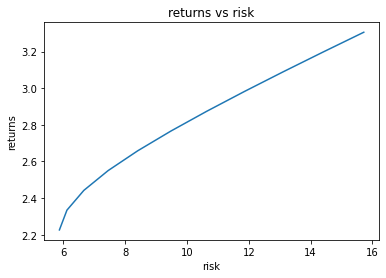

6.114841962989884


In [74]:
class Portfolio: 
    def __init__(self, ticker_1, ticker_2, period = "1mo"):
        self.stock_1 = Stock(ticker_1, period)    
        self.stock_2 = Stock(ticker_2, period)
    
    def get_return(self, w_1, w_2):
        exp_return = w_1 * self.stock_1.mean_return() + w_2 * self.stock_2.mean_return()
        return exp_return

    def risk(self, w_1, w_2):
        std_1 = self.stock_1.risk()
        std_2 = self.stock_2.risk()

        if w_1 < 0:
            w_sq_1 = -(w_1**2)
            w_sq_2 = w_2**2
        elif w_2 < 0: 
            w_sq_1 = w_1**2
            w_sq_2 = -(w_2**2)
        else: 
            w_sq_1 = w_1**2
            w_sq_2 = w_2**2
        
        variance = (w_sq_1 * (std_1**2)) + (w_sq_2 * (std_2**2)) + (2 * self.get_corr() * w_1 * w_2 * std_1 * std_2)
        risk = math.sqrt(variance)
        return risk

    # Gets the covariance of the two stocks
    def get_cov(self):
        returns1 = self.stock_1.period_returns()
        returns2 = self.stock_2.period_returns()

        # Makes the list of returns the same size
        abs_diff = abs(len(returns1) - len(returns2))
        if len(returns1) > len(returns2):
            returns1 = returns1[abs_diff:]
        else: 
            returns2 = returns2[abs_diff:]
        
        cov_matrix = np.cov(returns1,returns2)

        cov = cov_matrix[0,1]
        return cov
        

    def get_corr(self):
        corr = self.get_cov()/(self.stock_1.risk() * self.stock_2.risk())
        return corr

    def get_min_risk(self):
        std1 = self.stock_1.risk()
        std2 = self.stock_2.risk()

        numerator = (std2**2) - (self.get_corr() * std1 * std2)
        denominator = (std1**2) + (std2**2) - (2 * self.get_corr() * std1 * std2)

        stock_1_weight = numerator/denominator
        stock_2_weight = 1 - stock_1_weight

        return (stock_1_weight, stock_2_weight)
    
    def get_optimum(self): 
        std_1 = self.stock_1.risk()
        std_2 = self.stock_2.risk()
        rtrn_1 = self.stock_1.mean_return()
        rtrn_2 = self.stock_2.mean_return()

        numerator = rtrn_1 * (std_2**2) - rtrn_2 * (self.get_cov())
        denominator = rtrn_1*(std_2**2) + rtrn_2*(std_1**2) - (rtrn_1 + rtrn_2) * self.get_cov()

        stock_1_weight = numerator/denominator
        stock_2_weight = 1 - stock_1_weight

        return (stock_1_weight, stock_2_weight)
    
    def plot_risk_vs_return(self): 
        weights = []
        curr = 0
        while curr <= 1:
            weights.append(round(curr,1))
            curr += 0.1        
        
        returns = [self.get_return(x, 1-x) for x in weights]

        risk = [self.risk(x, 1-x) for x in weights]
        plt.plot(risk, returns)

        plt.xlabel('risk')
        plt.ylabel('returns')
        plt.title('returns vs risk')

        plt.show()
    

port = Portfolio('tsla', 'msft')

# port.plot_risk_vs_return()
# print(port.risk(0.1,0.9))

GridspecLayout(children=(Text(value='', description='Stock 1:', layout=Layout(grid_area='widget001')), Text(va…

Portfolio (tsla, msft) covariance: 38.851038888905755
Portfolio (tsla, msft) correlation coeff.: 0.42083403605464065
Portfolio (tsla, msft) minimum risk weights: (-0.021445240470887784, 1.0214452404708878)
Portfolio (tsla, msft) optmimum weights: (0.061108292284058875, 0.9388917077159411)


GridspecLayout(children=(FloatSlider(value=0.5, continuous_update=False, description='Stock 1:', layout=Layout…

Button(description='Get risk vs return graph', style=ButtonStyle())

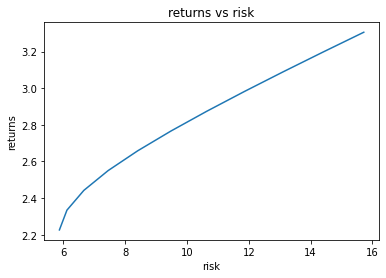

In [75]:
from ipywidgets import GridspecLayout

stock_text_1 = widgets.Text(
    description='Stock 1:',
)

stock_text_2 = widgets.Text(
    description='Stock 2:',
)

btn_list = [
    {"fname": "portfolio.get_cov()", "output_txt": "covariance"},
    {"fname": "portfolio.get_corr()", "output_txt": "correlation coeff."}, 
    {"fname": "portfolio.get_min_risk()", "output_txt": "minimum risk weights"},
    {"fname": "portfolio.get_optimum()", "output_txt": "optmimum weights"},
    ]


def add_txt(func, output_txt):
    ticker_1 = stock_text_1.value
    ticker_2 = stock_text_2.value
    portfolio = Portfolio(ticker_1, ticker_2)
    result = eval(func)
    output = "Portfolio ({ticker1}, {ticker2}) {txt}: {result}"
    print(output.format(ticker1 = ticker_1, ticker2 = ticker_2, txt = output_txt, result = result))

def add_btn(obj): 
    # Displays the results of the functions specified in btn_list
    i = 0
    while(i < len(btn_list)): 
        curr_func = btn_list[i]
        add_txt(curr_func["fname"], curr_func["output_txt"])
        i += 1

    # Grid for weight inputs
    weight_grid = GridspecLayout(2,2)
    # Int sliders for weight
    weight_1 = widgets.FloatSlider(
                value=0.5,
                min=0,
                max=1.0,
                step=0.05,
                description='Stock 1:',
                disabled=False,
                continuous_update=False,
                orientation='horizontal',
                readout=True,
                readout_format='.1f',
                )
    weight_2 = widgets.FloatSlider(
                value=0.5,
                min=0,
                max=1.0,
                step=0.05,
                description='Stock 2:',
                disabled=False,
                continuous_update=False,
                orientation='horizontal',
                readout=True,
                readout_format='.1f',
                )
    risk_return_btn = widgets.Button(description="Get risk and return")

    # Event handler for get risk and return button
    def risk_return_handler(obj):
        ticker_1 = stock_text_1.value
        ticker_2 = stock_text_2.value
        portfolio = Portfolio(ticker_1, ticker_2)
        risk = portfolio.risk(weight_1.value, weight_2.value)
        rtrn = portfolio.get_return(weight_1.value, weight_2.value)
        output = "Portfolio ({ticker1}, {ticker2}) {txt}: {result}"
        print(output.format(ticker1 = ticker_1, ticker2 = ticker_2, txt = "has risk", result = risk))
        print(output.format(ticker1 = ticker_1, ticker2 = ticker_2, txt = "has expected return", result = rtrn))

    risk_return_btn.on_click(risk_return_handler)

    weight_grid[0,0] = weight_1
    weight_grid[0,1] = weight_2
    weight_grid[1,0] = risk_return_btn

    display(weight_grid)

    graph_btn = widgets.Button(description="Get risk vs return graph")   

    def graph_handler(obj): 
        ticker_1 = stock_text_1.value
        ticker_2 = stock_text_2.value
        portfolio = Portfolio(ticker_1, ticker_2)
        portfolio.plot_risk_vs_return()
    
    graph_btn.on_click(graph_handler)
    display(graph_btn) 
grid = GridspecLayout(3,1)
grid[0,0] = stock_text_1
grid[1,0] = stock_text_2



display_btn = widgets.Button(description="Done")
display_btn.on_click(add_btn)
grid[2,0] = display_btn
display(grid)


        
    

# Market class

The market class can be instantiated by giving a list of asset tickers called a market


`min_risk_portfolio`: Returns an object containing the weights of two assets in the market that give the least risk <br>
`optimum_portfolio`: Returns an object containing the weights of two assets in the market that give the best sharpe ratio(most optimimum portfolio) <br>

Both functions are O(n^2) so it might take a while for larger lists!

In [6]:
class Market: 
  def __init__(self, market):
    self.market = market
    
  def min_risk_portfolio(self):
    curr_min_risk =  1000
    portfolio_info = {}

    for i in range(len(self.market)):
      for j in range(len(self.market[i:])):
        if i == j:
          continue
        
        portfolio = Portfolio(self.market[i], self.market[j])
        a,b = portfolio.get_min_risk() 
        portfolio_risk = portfolio.risk(a,b)

        if curr_min_risk > portfolio_risk:
          
          curr_min_risk = portfolio_risk
          portfolio_info['stock1'] = self.market[i]
          portfolio_info['stock2'] = self.market[j]
          portfolio_info['stock1_weight'] = a
          portfolio_info['stock2_weight'] = b
          portfolio_info['risk'] = portfolio_risk
        
        
    return portfolio_info

  def optimum_portfolio(self):
    curr_ratio =  -1000
    portfolio_info = {}

    for i in range(len(self.market)):
      for j in range(len(self.market[i:])):
        if i == j:
          continue
        
        portfolio = Portfolio(self.market[i], self.market[j])
        a,b = portfolio.get_optimium() 
        portfolio_return = portfolio.get_return(a,b)
        portfolio_risk = portfolio.risk(a,b)

        portfolio_ratio = portfolio_return/portfolio_risk

        if portfolio_ratio > curr_ratio:
          
          curr_min_risk = portfolio_ratio
          portfolio_info['stock1'] = self.market[i]
          portfolio_info['stock2'] = self.market[j]
          portfolio_info['stock1_weight'] = a
          portfolio_info['stock2_weight'] = b
          portfolio_info['sharpe_ratio'] = portfolio_ratio
        
        
    return portfolio_info

market1 = Market(['msft', 'aapl', 'tsla', 'amzn'])

# print(market1.optimum_portfolio())



